In [1]:
from config import MARKET_MODEL_DIR
from model_factory import build_market_neutral_model
import pickle
with open(MARKET_MODEL_DIR, "rb") as f:
    params = pickle.load(f)

model = build_market_neutral_model(**params)

Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23


In [2]:
from config import DATASET_DICT_PATH, TEST_DATASET_DICT_PATH
from io_utils import load_dataset_dict, create_dataset_from_dict
dataset_dict = load_dataset_dict(DATASET_DICT_PATH)
dataset_train = create_dataset_from_dict(dataset_dict, model)

>>> Precomputed mode enabled. Skipping time series processing and solution computation.


/Users/tarothousand/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
test_dataset_dict = load_dataset_dict(TEST_DATASET_DICT_PATH)
dataset_test = create_dataset_from_dict(test_dataset_dict, model)

>>> Precomputed mode enabled. Skipping time series processing and solution computation.


In [4]:
from config import K, HIDDEN_DIM, LSTM_HIDDEN_DIM, DROPOUT_RATE, DEVICE
from architecture import TwoLayerLSTM
lstm = TwoLayerLSTM(k=K, hidden_dim=HIDDEN_DIM, lstm_hidden_dim=LSTM_HIDDEN_DIM, dropout_rate=DROPOUT_RATE).to(DEVICE)
print("Model architecture:")
for name, param in lstm.named_parameters():
    print(f"{name:30s} | Shape: {param.data.shape} | Parameters: {param.numel()} | require_grad: {param.requires_grad}")
    print(f"Mean Value: {param.data.mean()} | Grad: {param.grad}")
    print("-" * 80)

Model architecture:
lstm.weight_ih_l0              | Shape: torch.Size([256, 6]) | Parameters: 1536 | require_grad: True
Mean Value: 0.0016319609712809324 | Grad: None
--------------------------------------------------------------------------------
lstm.weight_hh_l0              | Shape: torch.Size([256, 64]) | Parameters: 16384 | require_grad: True
Mean Value: 0.00043674424523487687 | Grad: None
--------------------------------------------------------------------------------
lstm.bias_ih_l0                | Shape: torch.Size([256]) | Parameters: 256 | require_grad: True
Mean Value: 0.00016901339404284954 | Grad: None
--------------------------------------------------------------------------------
lstm.bias_hh_l0                | Shape: torch.Size([256]) | Parameters: 256 | require_grad: True
Mean Value: 0.006989049259573221 | Grad: None
--------------------------------------------------------------------------------
fc_layers.0.weight             | Shape: torch.Size([64]) | Parameters

In [5]:
from data_loader import get_data_loaders
# 创建 Subset 类
from torch.utils.data import DataLoader
from config import BATCH_SIZE
# 假设 dataset_train, dataset_test 都是 optDataset 的实例
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
loader_test  = DataLoader(dataset_test,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

loader_train, loader_test = get_data_loaders(dataset_train, dataset_test)

In [6]:
from train import trainModel
from config import NUM_EPOCHS, BATCH_SIZE, LR, LSTM_SAVE_DIR
import os
os.makedirs(LSTM_SAVE_DIR, exist_ok=True)   
import pyepo
import torch 

spop = pyepo.func.SPOPlus(model)
loss_log, loss_log_regret = trainModel(
    lstm, 
    loss_func=spop, 
    method_name="spo+",
    loader_train=loader_train,
    loader_test=loader_test,
    market_neutral_model=model,
    num_epochs=NUM_EPOCHS,  # Increased for better convergence
    lr=LR        # Adjusted learning rate
)

lstm_save_path = os.path.join(LSTM_SAVE_DIR, "trial_13_assets.pt")
torch.save({
    'model_state_dict': lstm.state_dict(),
    'loss_log': loss_log,
    'loss_log_regret': loss_log_regret
}, lstm_save_path)

print(f"模型参数已保存到 {lstm_save_path}")

Num of cores: 1


/Users/tarothousand/Library/Python/3.11/lib/python/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Initial regret: 54.6036%


Epoch 1/3: 100%|██████████| 13101/13101 [04:45<00:00, 45.82it/s, loss=0.0047, batch time=0.0184s]


Epoch 1: Loss=0.005099, Regret=56.8625%, Time=319.04s


Epoch 2/3: 100%|██████████| 13101/13101 [04:44<00:00, 45.99it/s, loss=0.0059, batch time=0.0184s]


Epoch 2: Loss=0.004478, Regret=57.6365%, Time=316.46s


Epoch 3/3: 100%|██████████| 13101/13101 [04:47<00:00, 45.56it/s, loss=0.0040, batch time=0.0183s]


Epoch 3: Loss=0.004387, Regret=57.5624%, Time=320.51s
Total training time: 956.01s, Effective computation time: 735.45s
模型参数已保存到 ./lstm/trial_13_assets.pt



Visualizing learning curves...


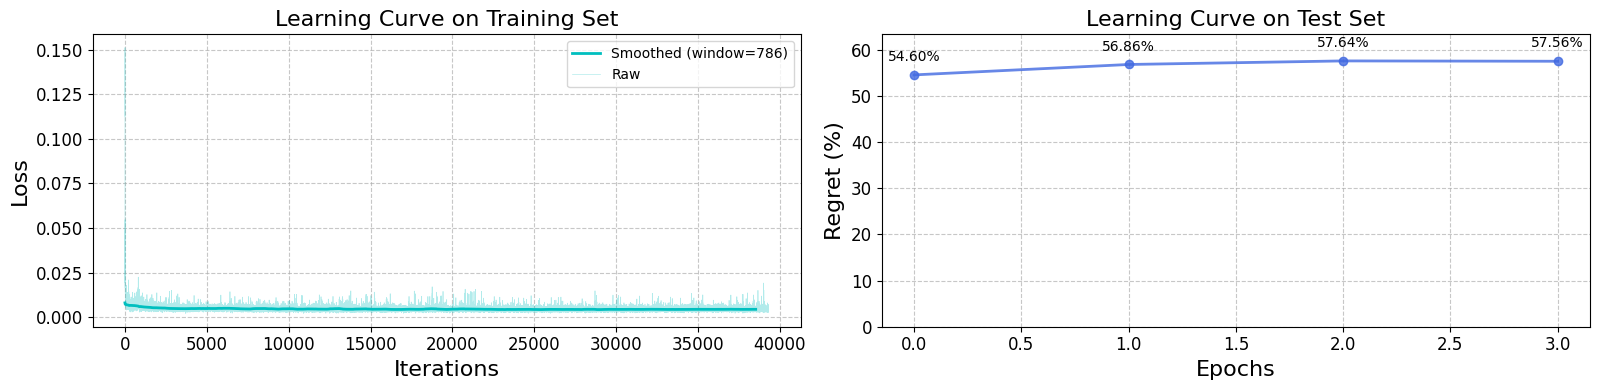

In [7]:
#############################################################################
# VISUALIZATION
#############################################################################
from matplotlib import pyplot as plt
import numpy as np


def visLearningCurve(loss_log, loss_log_regret):
    """Enhanced visualization with smoother curves and more information"""
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
    
    # Plot training loss with smoothing for readability
    n_points = len(loss_log)
    
    # Apply smoothing for large datasets
    if n_points > 100:
        window_size = max(10, n_points // 50)
        smoothed_loss = np.convolve(loss_log, np.ones(window_size)/window_size, mode='valid')
        x_axis = np.arange(len(smoothed_loss))
        ax1.plot(x_axis, smoothed_loss, color="c", lw=2, label=f"Smoothed (window={window_size})")
        # Also plot the raw data with transparency
        ax1.plot(loss_log, color="c", lw=0.5, alpha=0.3, label="Raw")
        ax1.legend()
    else:
        # For smaller datasets, just plot the raw data
        ax1.plot(loss_log, color="c", lw=2)
    
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iterations", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Draw plot for regret on test set
    epochs = np.arange(len(loss_log_regret))
    ax2.plot(epochs, [r*100 for r in loss_log_regret], 
             color="royalblue", marker='o', ls="-", alpha=0.8, lw=2)
    
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, max(50, max([r*100 for r in loss_log_regret])*1.1))  # Dynamic y-limit
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret (%)", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Add values to points
    for i, r in enumerate(loss_log_regret):
        ax2.annotate(f"{r*100:.2f}%", 
                     (i, r*100),
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center')
    
    plt.tight_layout()
    # plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    # print("Saved learning curves to 'learning_curves.png'")
    plt.show()

print("\nVisualizing learning curves...")
visLearningCurve(loss_log, loss_log_regret)

### 回测

In [8]:
from train import trainModel
from config import NUM_EPOCHS, BATCH_SIZE, LR, LSTM_SAVE_DIR
import pyepo
import torch 
import os

lstm_save_path = os.path.join(LSTM_SAVE_DIR, "trial_13_assets.pt")
lstm_eval = TwoLayerLSTM(k=K, hidden_dim=HIDDEN_DIM, lstm_hidden_dim=LSTM_HIDDEN_DIM, dropout_rate=DROPOUT_RATE).to(DEVICE)
checkpoint = torch.load(lstm_save_path, map_location=DEVICE, weights_only=False)
lstm_eval.load_state_dict(checkpoint['model_state_dict'])
print("Model architecture after training:")
for name, param in lstm_eval.named_parameters():
    print(f"{name:30s} | Shape: {param.data.shape} | Parameters: {param.numel()} | require_grad: {param.requires_grad}")
    print(f"Mean Value: {param.data.mean()} | Grad: {param.grad}")
    print("-" * 80)

Model architecture after training:
lstm.weight_ih_l0              | Shape: torch.Size([256, 6]) | Parameters: 1536 | require_grad: True
Mean Value: 0.08156098425388336 | Grad: None
--------------------------------------------------------------------------------
lstm.weight_hh_l0              | Shape: torch.Size([256, 64]) | Parameters: 16384 | require_grad: True
Mean Value: 0.012302311137318611 | Grad: None
--------------------------------------------------------------------------------
lstm.bias_ih_l0                | Shape: torch.Size([256]) | Parameters: 256 | require_grad: True
Mean Value: -0.16120581328868866 | Grad: None
--------------------------------------------------------------------------------
lstm.bias_hh_l0                | Shape: torch.Size([256]) | Parameters: 256 | require_grad: True
Mean Value: -0.16908016800880432 | Grad: None
--------------------------------------------------------------------------------
fc_layers.0.weight             | Shape: torch.Size([64]) | P

In [10]:
import numpy as np
# set lstm to evaluation mode
lstm_eval.eval()

pred_returns = [] # predicted returns
with torch.no_grad():
    for x, _, _, _ in loader_test:
        # 1. 预测 returns
        x = x.to(DEVICE)                      # (batch_size, N, lookback, k)
        pred_return = lstm_eval(x)                   # (batch_size, N)
        pred_return = pred_return.cpu().numpy()             # 转成ndarray
        pred_returns.append(pred_return)

pred_returns = np.vstack(pred_returns) # (T, N)
print(f"预测的收益率矩阵形状是: {pred_returns.shape}")

预测的收益率矩阵形状是: (26202, 13)


In [11]:
feats_test = np.load("/Users/tarothousand/Desktop/EndToEnd/my-PyEPO/00_portfolio_real_data/test_data/features_crypto_data.npy")
print(f"测试集feature的形状是: {feats_test.shape}")

测试集feature的形状是: (26202, 13, 6)


In [12]:
### 优化器
from config import PRECOMPUTE_BATCH_SIZE, LOOKBACK, PADDING_METHOD
from batch_runner import process_and_combine_shared
dataset_dict_test = process_and_combine_shared(feats_test, pred_returns, batch_size=PRECOMPUTE_BATCH_SIZE, **params)


 共享内存子进程处理样本 0 到 499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3822.78it/s]



 共享内存子进程处理样本 500 到 999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3838.98it/s]



 共享内存子进程处理样本 1000 到 1499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3681.86it/s]



 共享内存子进程处理样本 1500 到 1999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3793.31it/s]



 共享内存子进程处理样本 2000 到 2499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3854.28it/s]



 共享内存子进程处理样本 2500 到 2999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3956.08it/s]



 共享内存子进程处理样本 3000 到 3499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3981.43it/s]



 共享内存子进程处理样本 3500 到 3999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3866.74it/s]



 共享内存子进程处理样本 4000 到 4499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3911.71it/s]



 共享内存子进程处理样本 4500 到 4999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3994.16it/s]



 共享内存子进程处理样本 5000 到 5499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3956.51it/s]



 共享内存子进程处理样本 5500 到 5999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3892.50it/s]



 共享内存子进程处理样本 6000 到 6499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3894.32it/s]



 共享内存子进程处理样本 6500 到 6999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3902.68it/s]



 共享内存子进程处理样本 7000 到 7499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3795.39it/s]



 共享内存子进程处理样本 7500 到 7999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3938.11it/s]



 共享内存子进程处理样本 8000 到 8499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3744.09it/s]



 共享内存子进程处理样本 8500 到 8999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3766.13it/s]



 共享内存子进程处理样本 9000 到 9499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3933.25it/s]



 共享内存子进程处理样本 9500 到 9999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3753.47it/s]



 共享内存子进程处理样本 10000 到 10499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3924.34it/s]



 共享内存子进程处理样本 10500 到 10999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3974.40it/s]



 共享内存子进程处理样本 11000 到 11499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3748.88it/s]



 共享内存子进程处理样本 11500 到 11999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3915.67it/s]



 共享内存子进程处理样本 12000 到 12499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3904.75it/s]



 共享内存子进程处理样本 12500 到 12999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3960.21it/s]



 共享内存子进程处理样本 13000 到 13499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3816.24it/s]



 共享内存子进程处理样本 13500 到 13999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3895.99it/s]



 共享内存子进程处理样本 14000 到 14499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3909.48it/s]



 共享内存子进程处理样本 14500 到 14999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3893.39it/s]



 共享内存子进程处理样本 15000 到 15499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3993.92it/s]



 共享内存子进程处理样本 15500 到 15999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3858.54it/s]



 共享内存子进程处理样本 16000 到 16499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3884.25it/s]



 共享内存子进程处理样本 16500 到 16999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3883.07it/s]



 共享内存子进程处理样本 17000 到 17499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3959.24it/s]



 共享内存子进程处理样本 17500 到 17999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3852.29it/s]



 共享内存子进程处理样本 18000 到 18499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3874.65it/s]



 共享内存子进程处理样本 18500 到 18999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3712.14it/s]



 共享内存子进程处理样本 19000 到 19499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3688.73it/s]



 共享内存子进程处理样本 19500 到 19999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3041.97it/s]



 共享内存子进程处理样本 20000 到 20499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3763.19it/s]



 共享内存子进程处理样本 20500 到 20999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3883.95it/s]



 共享内存子进程处理样本 21000 到 21499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3870.54it/s]



 共享内存子进程处理样本 21500 到 21999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3999.72it/s]



 共享内存子进程处理样本 22000 到 22499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3915.45it/s]



 共享内存子进程处理样本 22500 到 22999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3890.29it/s]



 共享内存子进程处理样本 23000 到 23499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3925.24it/s]



 共享内存子进程处理样本 23500 到 23999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3904.85it/s]



 共享内存子进程处理样本 24000 到 24499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3936.48it/s]



 共享内存子进程处理样本 24500 到 24999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3879.13it/s]



 共享内存子进程处理样本 25000 到 25499...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 4006.57it/s]



 共享内存子进程处理样本 25500 到 25999...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 3940.50it/s]



 共享内存子进程处理样本 26000 到 26201...
Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 202/202 [00:00<00:00, 3964.07it/s]



 合并所有批次...


In [13]:
# 测试集仓位
positions = dataset_dict_test["sols"]
print(f"测试集仓位的形状是: {positions.shape}")

测试集仓位的形状是: (26202, 13)


In [14]:
pnl_series = []
for i in range(len(positions)):
    pnl = np.nansum(positions[i] * dataset_dict["costs"][i])
    pnl_series.append(pnl)
print(f"pnl series的长度是: {len(pnl_series)}")

pnl series的长度是: 26202


### Visualize Cumulative Pnl

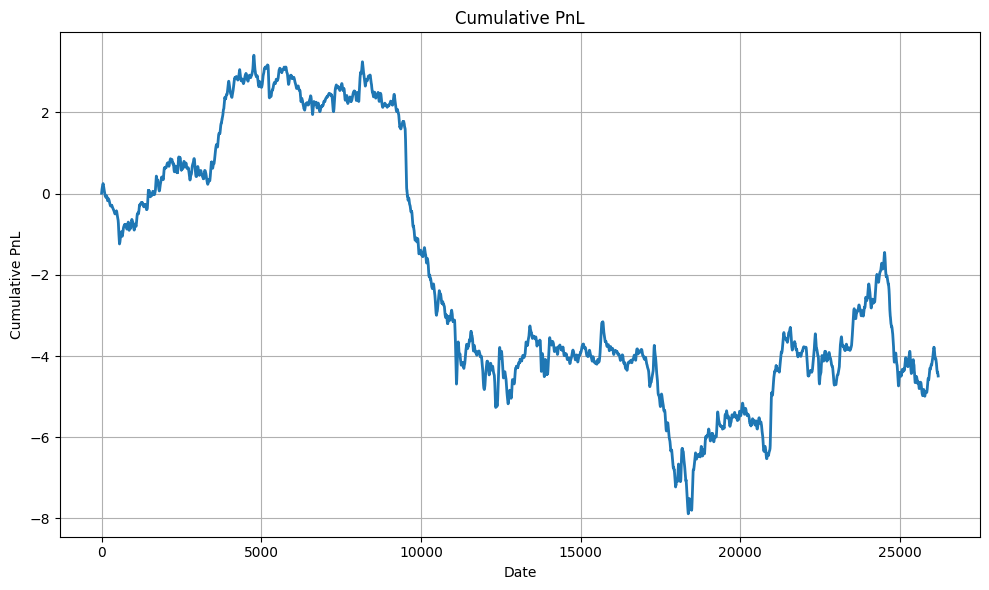

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_cum_pnl_series(pnl_series, title='Cumulative PnL', figsize=(10, 6)):
    """
    绘制累计 PnL 曲线。

    参数
    -----
    pnl_series : pandas.Series
        每期的 PnL 序列，索引为日期或时间点。
    title : str, optional
        图表标题，默认 'Cumulative PnL'。
    figsize : tuple, optional
        图表大小，默认为 (10, 6)。
    """
    # 计算累计 PnL
    cum_pnl = pd.Series(pnl_series).cumsum()

    # 绘图
    plt.figure(figsize=figsize)
    plt.plot(np.arange(len(cum_pnl)), cum_pnl.values, linewidth=2)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative PnL')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_cum_pnl_series(pnl_series)
